# Description

An image segmenator (resizes to 160) for food. It is based on the imagenet weights and uses the food103 dataset from tensorflow. It is for the specific use case of tensorflow js

# Features

- Full dataset download and process
- Full model exported to tensorflowjs
- Plot of Predicted mask vs True mask
- Plot of loss over epochs

# Author

Jonathan Coletti (jonathancoletti0@gmail.com)

LICENSE -- Apache 2.0

In [1]:

!pip install tensorflow==2.15 tensorflow-datasets tensorflowjs matplotlib kagglehub tensorflowjs[wizard] datasets
!pip install -q git+https://github.com/tensorflow/examples.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 29.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 KB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 74.5 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 KB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 66.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 KB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.5 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import os
from datasets import load_dataset
from tensorflow_examples.models.pix2pix import pix2pix



## Dataset

**Dataset:** 

[`EduardoPacheco/FoodSeg103`](https://huggingface.co/datasets/EduardoPacheco/FoodSeg103)

- ~7,000 images
- 103 food categories
- Each image has a corresponding semantic mask labeling food regions
- Images + masks are resized to **128×128** for training



## Model Architecture (U-Net with MobileNetV2 Encoder)

The model follows a U-Net (encoder decoder) structure with skip connections, where the encoder is initialized from a pretrained MobileNetV2 network (made for tensorflowjs)

### Encoder 

- Based on MobileNetV2
- Gets multi-scale feature maps from several (SKIP_LAYERS) layers
- Each encoder block reduces spatial dimensions (downsampling) and increases feature depth
- Produces intermediate features 

### Bottleneck

- The deepest part of the encoder
- Captures semantic + contextual information at the lowest spatial resolution
- Provides a compact representation for decoding

### Decoder

A sequence of transposed convolution and upsampling blocks

1. The decoder feature map is upsampled
2. Concat with the corresponding encoder feature map
3. Combined through additional convolutional layers




# Constants

In [4]:
DATASET_PATH = load_dataset("EduardoPacheco/FoodSeg103")
IMG_SIZE = 128
BATCH_SIZE = 8
SKIP_LAYERS = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

MAX_8_BIT_RGB_IMAGE = 255.0

FEATURE_MAP_DIM = 256
FEATURE_MAP_OUT_DIM = FEATURE_MAP_DIM // 2 # 128
UP_SAMPLING_AMOUNT = (2, 2)
LEARNING_RATE = 1e-4
N_CLASSES = 104

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

In [5]:
print("GPU OR NO?", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU OR NO? True


2025-10-06 15:24:19.722153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1d:00.0, compute capability: 7.0


In [7]:
def normalize(input_image, input_mask):
  # image to float and scale to [0, 1] range
  input_image = tf.cast(input_image, tf.float32) / 255.0
  # input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  
  # get the label (mask)
  input_mask = datapoint['label']
  
  # shape (height, width) -> (height, width, 1)
  input_mask = tf.expand_dims(input_mask, axis=-1)

  # resize the 3D mask tensor
  input_mask = tf.image.resize(
    input_mask,
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return {'image': input_image, 'label': input_mask}

train_ds = DATASET_PATH['train'].map(load_image)
val_ds = DATASET_PATH['validation'].map(load_image)



Map:   0%|          | 0/4983 [00:00<?, ? examples/s]

/venv/main/lib/python3.10/site-packages/datasets/features/image.py:352: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Map:   0%|          | 0/2135 [00:00<?, ? examples/s]

In [8]:
train = train_ds
test = val_ds

base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_SIZE, IMG_SIZE, 3], include_top=False)

# Use the activations of these layers
base_model_outputs = [base_model.get_layer(name).output for name in SKIP_LAYERS]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    
    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # Upsampling and create the skip connections
    for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])
    
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(output_channels=N_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


9406464/9406464 [==============================] - 22s 2us/step


In [11]:


train_batches = train_ds.to_tf_dataset(
    columns='image',          # feature column
    label_cols='label',       # label column
    shuffle=True,
    batch_size=BATCH_SIZE,
)

test_batches = val_ds.to_tf_dataset(
    columns='image',
    label_cols='label',
    shuffle=False,
    batch_size=BATCH_SIZE,
)

# train_batches = train_batches.map(Augment())

train_batches = train_batches.prefetch(buffer_size=tf.data.AUTOTUNE)
test_batches = test_batches.prefetch(buffer_size=tf.data.AUTOTUNE)

NUM_OF_PASSES_THROUGH_DATASET = 1
model_history = model.fit(
    train_batches,
    epochs=NUM_OF_PASSES_THROUGH_DATASET,
    validation_data=test_batches
)



test_batches = val_ds.batch(BATCH_SIZE)

model_history = model.fit(train_batches, epochs=NUM_OF_PASSES_THROUGH_DATASET, validation_data=test_batches)


2025-10-06 15:56:37.495379: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-10-06 15:56:38.534856: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6210b6f160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-06 15:56:38.534899: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-10-06 15:56:38.550479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759766198.688444    2760 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


623/623 [==============================] - 1486s 2s/step - loss: 2.0916 - accuracy: 0.5222 - val_loss: 3.3059 - val_accuracy: 0.4639


Batching examples:   0%|          | 0/2135 [00:00<?, ? examples/s]

623/623 [==============================] - ETA: 0s - loss: 1.7267 - accuracy: 0.5745   

ValueError: Failed to find data adapter that can handle input: <class 'datasets.arrow_dataset.Dataset'>, <class 'NoneType'>

In [18]:
sample = next(iter(test_batches))
sample_img = sample['image']   # shape (B, 128, 128, 3)
sample_mask = sample['label']  # shape (B, 128, 128, 1)
pred_mask = model.predict(sample_img)  # shape (BATCH_SIZE, 128, 128, N_CLASSES)

1/1 [==============================] - 1s 713ms/step


# Plot predicted mask vs true mask

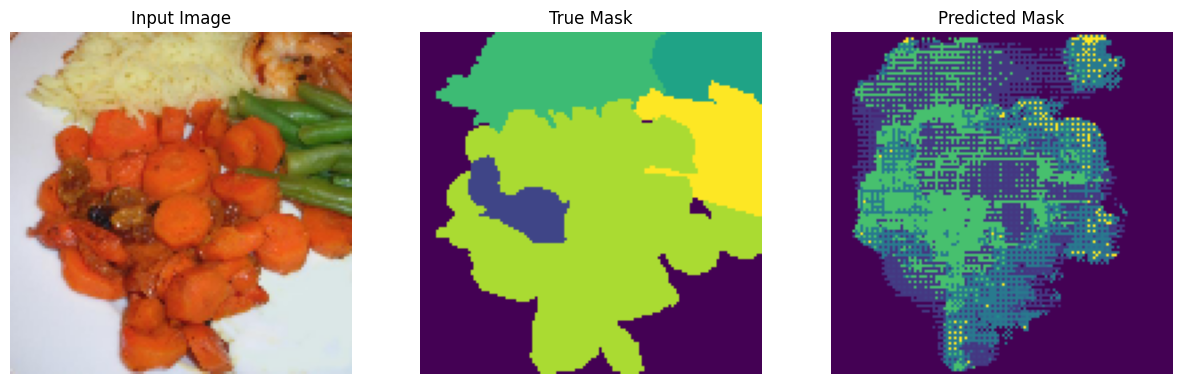

In [19]:
pred_mask = tf.argmax(pred_mask, axis=-1)
pred_mask = tf.expand_dims(pred_mask, axis=-1)

sample_image = sample_img[0]
sample_true_mask = sample_mask[0]
sample_pred_mask = pred_mask[0]

def display_sample(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

display_sample([sample_image, sample_true_mask, sample_pred_mask])

# Plot of loss, accuracy / epochs
- Training loss
- Training accuracy
- NOTE: WONT WORK WITH ONLY ONE EPOCH

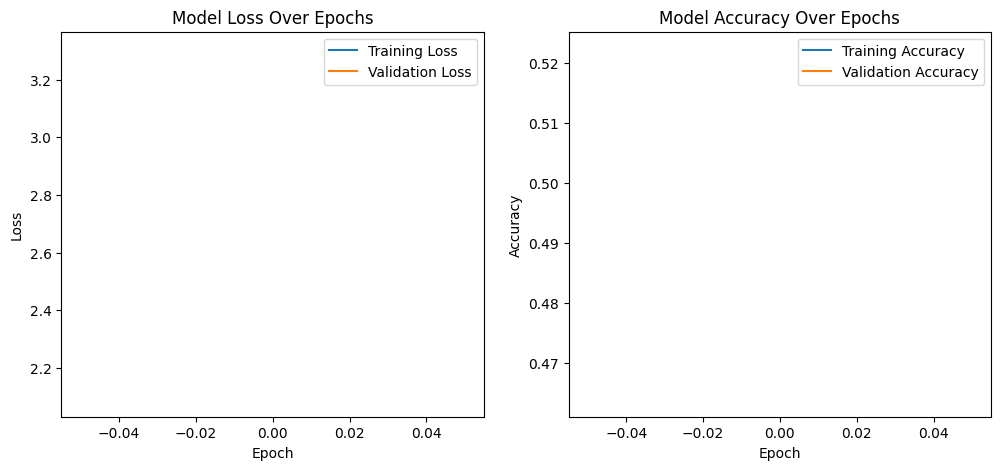

In [24]:
plt.figure(figsize=(12, 5)) 

plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Saving the database for use in tensorflow js

In [25]:
!mkdir -p tfjs_food_seg
model.save(f'tfjs_food_seg/my_model.h5', save_format='h5')

/venv/main/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/venv/main/lib/python3.10/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [26]:
!mkdir web_model
!tensorflowjs_converter --input_format keras tfjs_food_seg/my_model.h5 ./web_model

2025-10-06 16:53:56.068321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-06 16:53:56.068373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-06 16:53:56.069949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
